In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
from scipy.stats import binned_statistic
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [6]:
nside = 64
s = maf.HealpixSlicer(nside=nside)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [29]:
# Metric in development

class TemplateTime(maf.BaseMetric):
    """Find the time at which we expect to hit incremental template availability.
    
    Note that there are some complications to real template generation that make this an 
    approximation and not an exact answer -- one aspect is that templates are generated in 
    `patches` and not per pixel. However, it may be possible to generate parts of these patches
    at about 5arcsecond scales, which implies running with a healpix slicer at nside=512 or 1024. 
    
    Parameters
    ----------
    n_visits : `int`, opt
        Number of qualified visits required for incremental template generation. 
        Default 3. 
    seeing_range : `float`, opt
        Range of seeing to allow in the qualified images. 
    m5_range : `float`, opt
        Range of m5 values to allow in the qualified images. Stand in for `weight` in template.
    seeingCol : `str`, opt
        Name of the seeing column to use.
    m5Col : `str`, opt
        Name of the five sigma depth columns.
    nightCol : `str`, opt
        Name of the column describing the night of the visit.
    """
    
    def __init__(self, n_visits=3, seeing_ratio=2.0, m5_range=0.5, 
                 seeingCol='seeingFwhmEff', m5Col='fiveSigmaDepth',
                 nightCol = 'night', **kwargs):
        self.n_visits = n_visits
        self.seeing_ratio = seeing_ratio
        self.m5_range = m5_range
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.nightCol = nightCol
        if 'metric_name' in kwargs:
            self.metric_name = kwargs['metric_name']
            del kwargs['metric_name']
        else:
            self.metric_name = 'TemplateTime'
        super().__init__(col=[self.seeingCol, self.m5Col, self.nightCol],
                         metric_name=self.metric_name, units="days", **kwargs)
        # Looking at names of seeing columns, five sigma depth, and nights associated with template visits

    def run(self, dataSlice, slice_point=None):
        # Bail if not enough visits at all
        if len(dataSlice) < self.n_visits:
            return self.badval
        
        # Check that the visits are sorted in night
        dataSlice.sort(order=self.nightCol)
        
        # Find the best seeing in the first few images
        bench_seeing = np.percentile(dataSlice[self.seeingCol],25)
        bench_m5 = np.percentile(dataSlice[self.m5Col],25)
        
        #Checks whether data was collected on night where seeing conditions were preferable
        seeing_ok = np.where(dataSlice[self.seeingCol]/bench_seeing < self.seeing_ratio, 
                            True, False)
        
        #Checks whether data was collected where seeing range was preferable
        m5_ok = np.where(bench_m5 - dataSlice[self.m5Col] < self.m5_range,
                        True, False)

        both = np.where(seeing_ok & m5_ok)[0]
        if len(both) < self.n_visits: # If seeing_ok and/or m5_ok are "false", returned as bad value
            return self.badval
            
        idx_template = both[self.n_visits - 1] # Nights visited
        
        n_template = dataSlice[self.nightCol][idx_template] # Night of template creation
        d_n = n_template - dataSlice[self.nightCol][0] # Number of nights for a template
        
        image_template = np.sum(dataSlice[self.nightCol] > n_template) # of later images where we have a template
        
        template_m5 = 1.25 * np.log10(np.sum(10.0 ** (0.8 * dataSlice[self.m5Col][idx_template])))
        
        diff_m5s = 1.25 * np.log10((10.0 ** (0.8 * dataSlice[self.m5Col]))
                                 +(10.0 ** (0.8 * template_m5)))

        return [n_template, d_n, idx_template + 1, image_template, template_m5, diff_m5s]
    
        
    def reduceNight(self, metricVal): # returns night of template creation
        return metricVal[0]
    
    def reduceDeltaNight(self, metricVal): # returns number of nights needed to complete template
        return metricVal[1]
    
    def reduceNVis(self, metricVal): # returns number of images needed to complete template
        return metricVal[2]
    
    def reduceImage(self, metricVal): # returns number of images in a template
        return metricVal[3]
    
    def reduceTemplate_m5(self, metricVal): # calculated coadded m5 of resulting template
        return metricVal[4]
    
    def reduceDiff_m5s(self, metricVal):
        return metricVal[5]

In [30]:
opsdb = get_baseline()
run_name = os.path.split(opsdb)[-1].replace('.db', '')

In [ ]:
bdict = {}
for f in 'ugrizy':
    m = TemplateTime(metric_name=f'Template {f}')
    constraint = f'filter == "{f}" and night < 365'
    bdict[f] = maf.MetricBundle(m, s, constraint, run_name=run_name)
    
g = maf.MetricBundleGroup(bdict, opsdb, 'temp')
g.run_all()

In [32]:
bdict.metric_values

AttributeError: 'dict' object has no attribute 'metric_values'

In [24]:
bdict.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'y', 'Template u_reduceDeltaNight', 'Template u_reduceImage', 'Template u_reduceNVis', 'Template u_reduceNight', 'Template u_reduceTemplate_m5', 'Template z_reduceDeltaNight', 'Template z_reduceImage', 'Template z_reduceNVis', 'Template z_reduceNight', 'Template z_reduceTemplate_m5', 'Template r_reduceDeltaNight', 'Template r_reduceImage', 'Template r_reduceNVis', 'Template r_reduceNight', 'Template r_reduceTemplate_m5', 'Template g_reduceDeltaNight', 'Template g_reduceImage', 'Template g_reduceNVis', 'Template g_reduceNight', 'Template g_reduceTemplate_m5', 'Template y_reduceDeltaNight', 'Template y_reduceImage', 'Template y_reduceNVis', 'Template y_reduceNight', 'Template y_reduceTemplate_m5', 'Template i_reduceDeltaNight', 'Template i_reduceImage', 'Template i_reduceNVis', 'Template i_reduceNight', 'Template i_reduceTemplate_m5'])

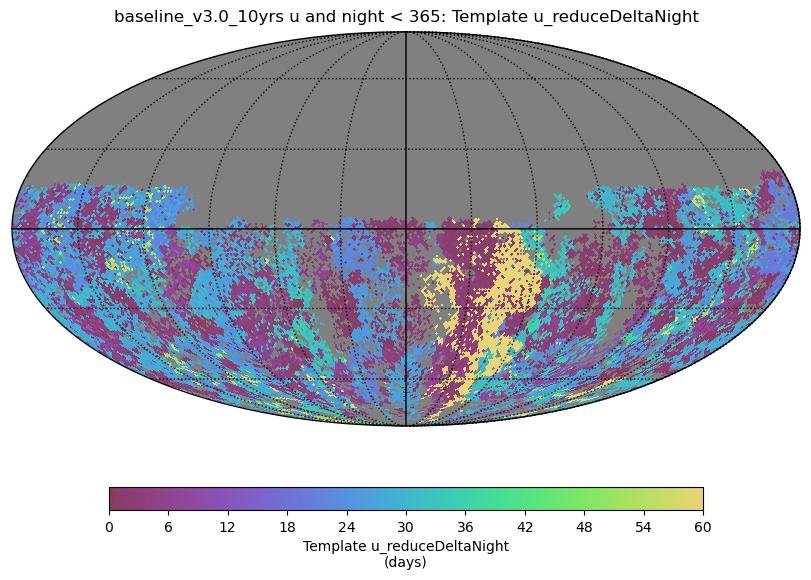

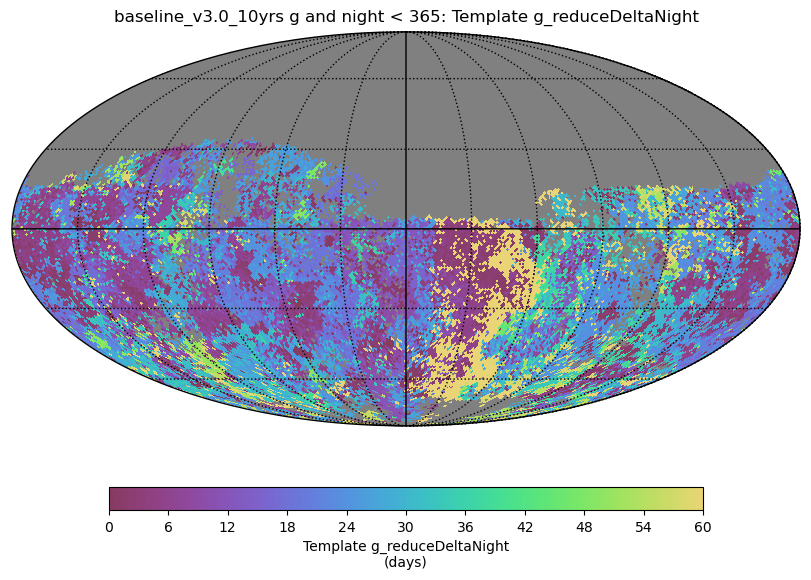

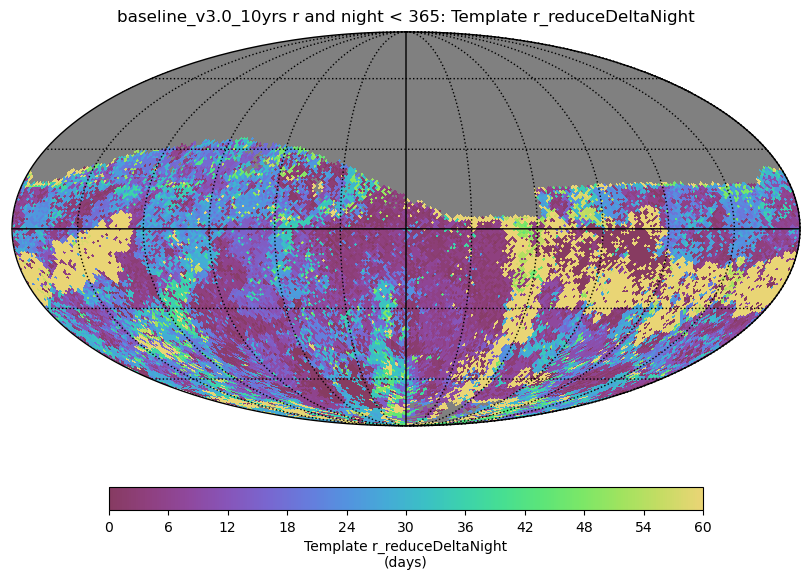

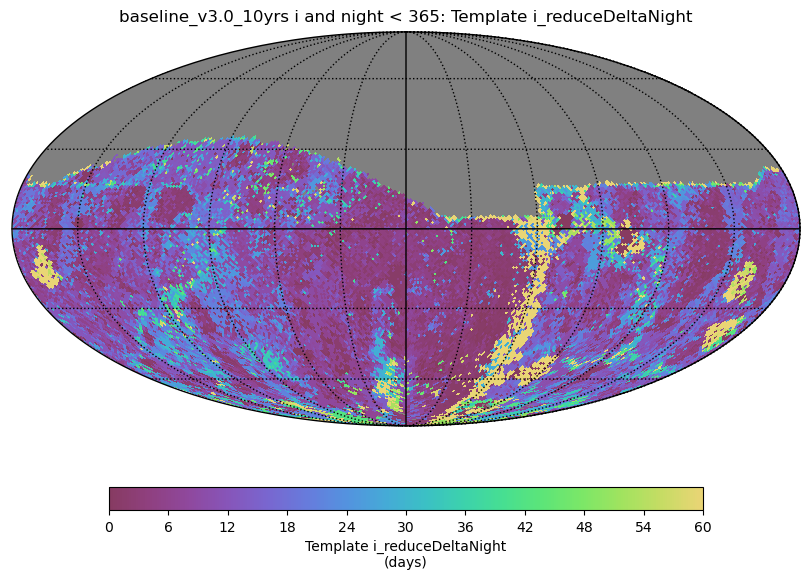

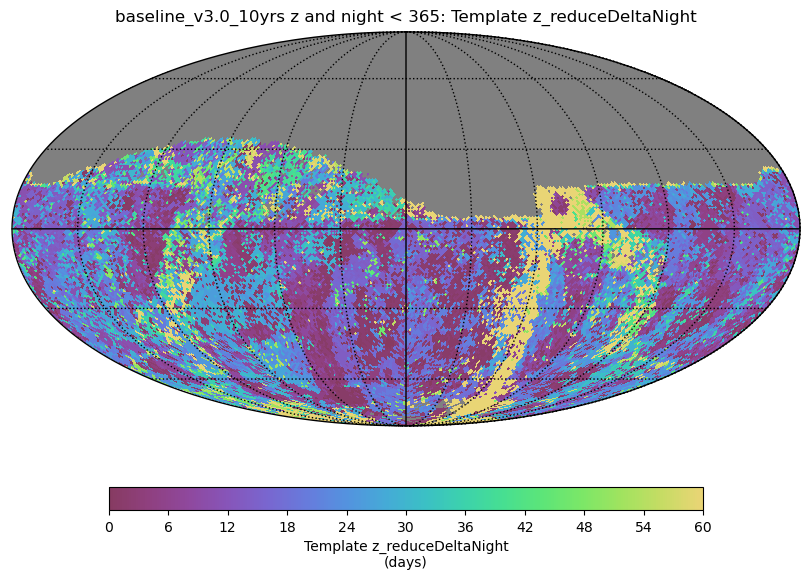

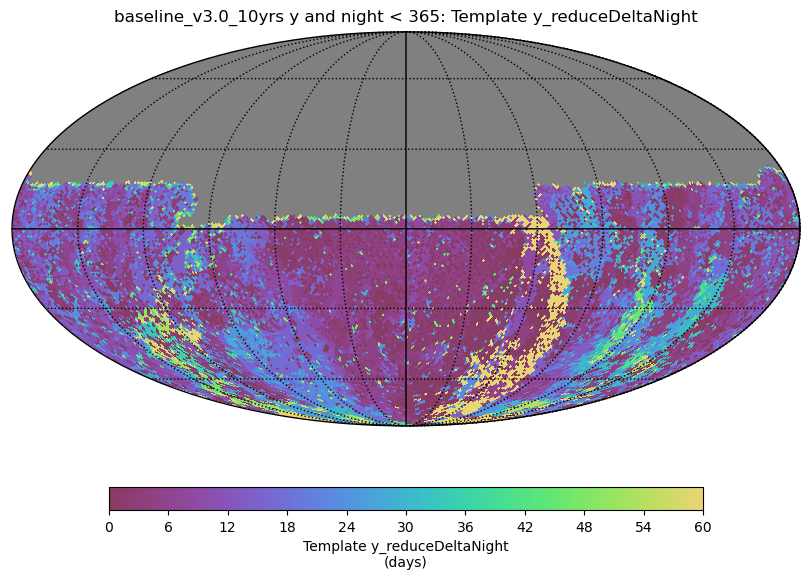

In [18]:
ph = maf.PlotHandler(out_dir='temp', thumbnail=False)

for f in 'ugrizy':
    k = f'Template {f}_reduceDeltaNight'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 0, 'color_max': 60}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)

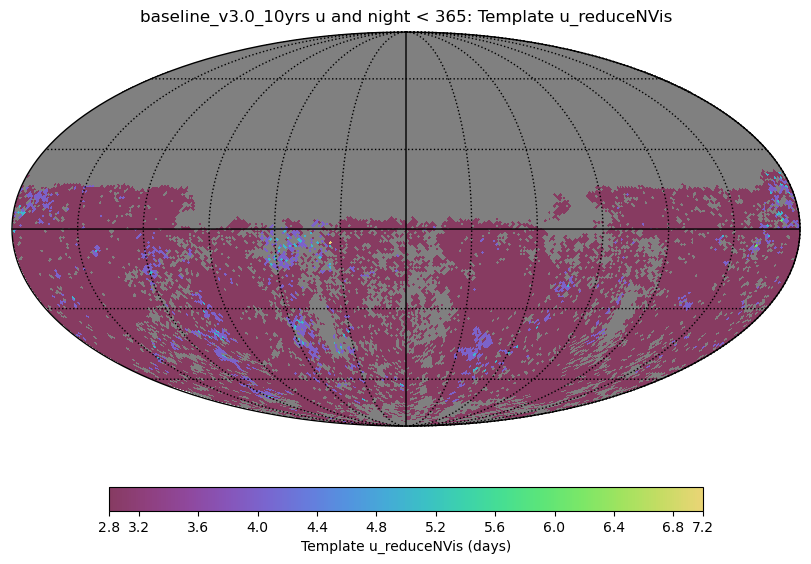

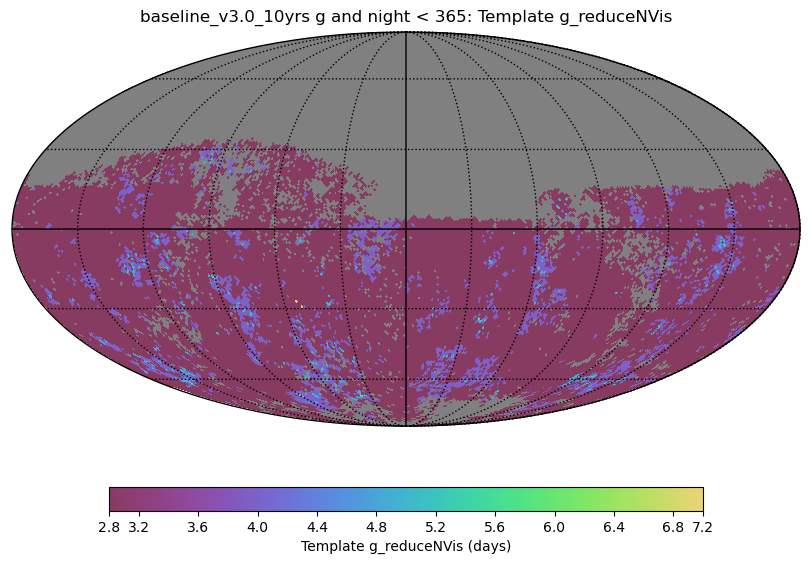

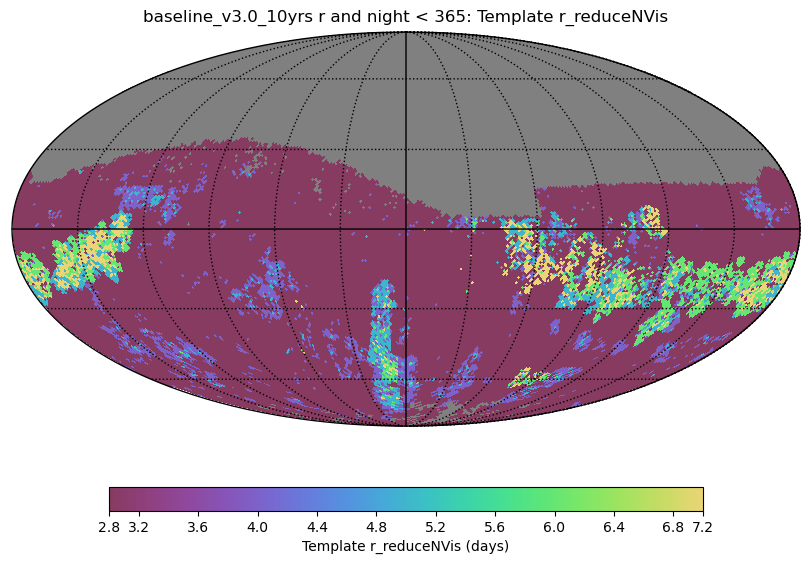

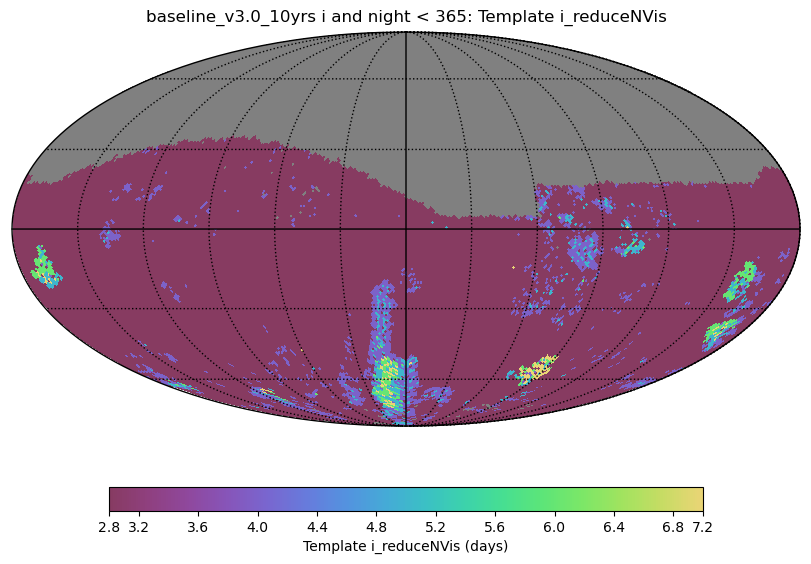

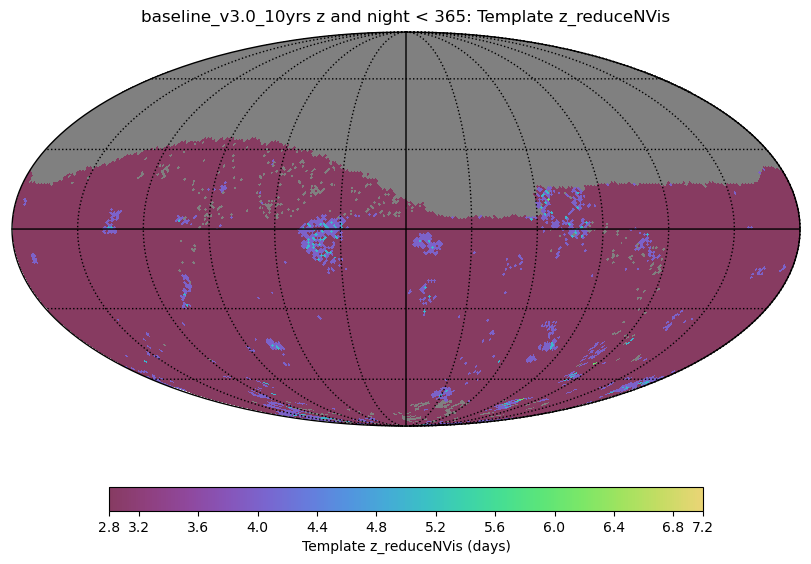

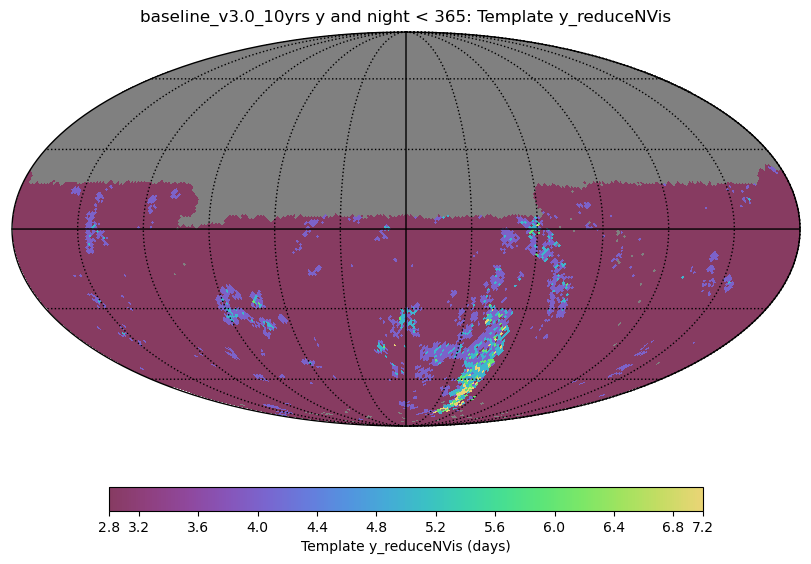

In [19]:
for f in 'ugrizy':
    k = f'Template {f}_reduceNVis'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 3, 'color_max': 7}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)

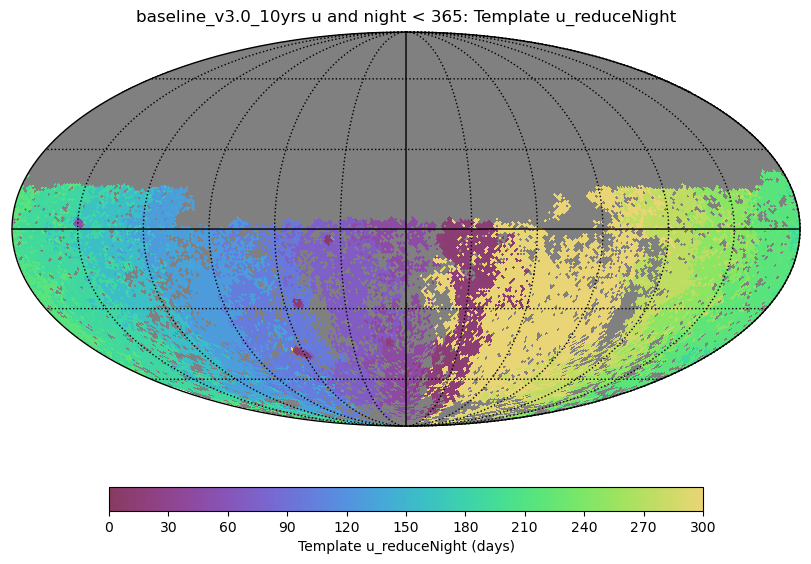

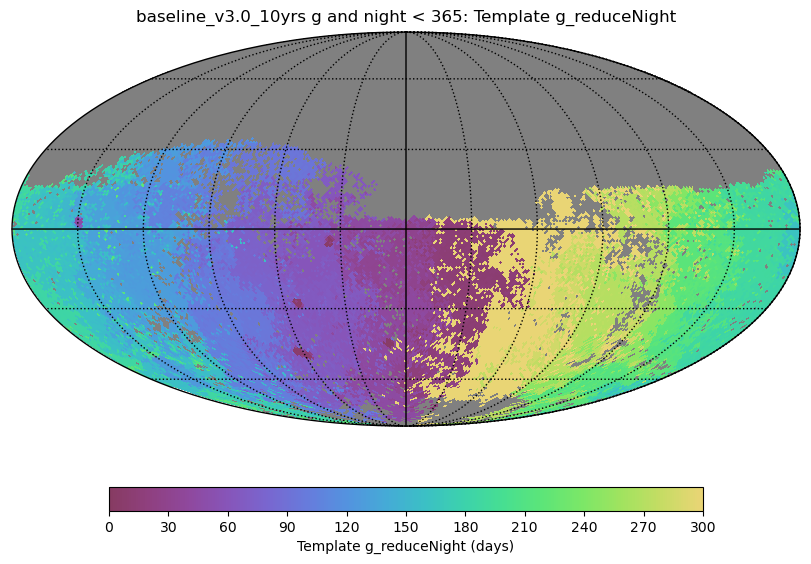

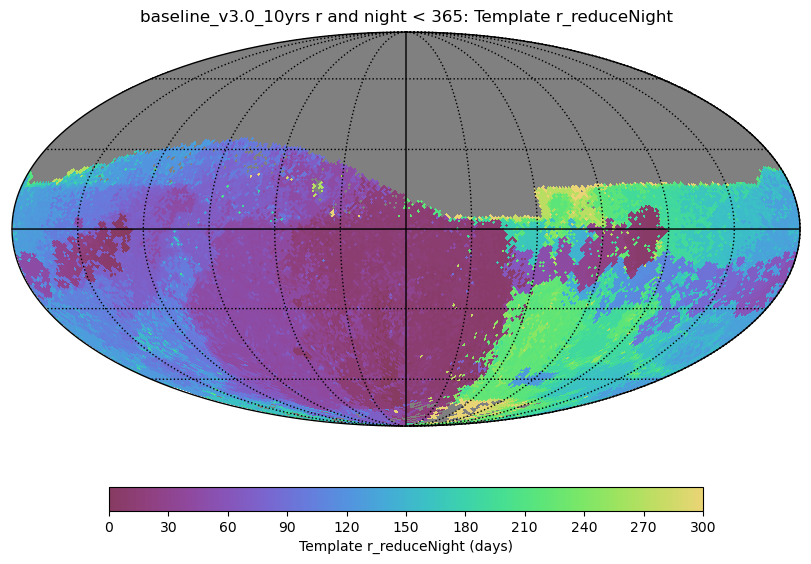

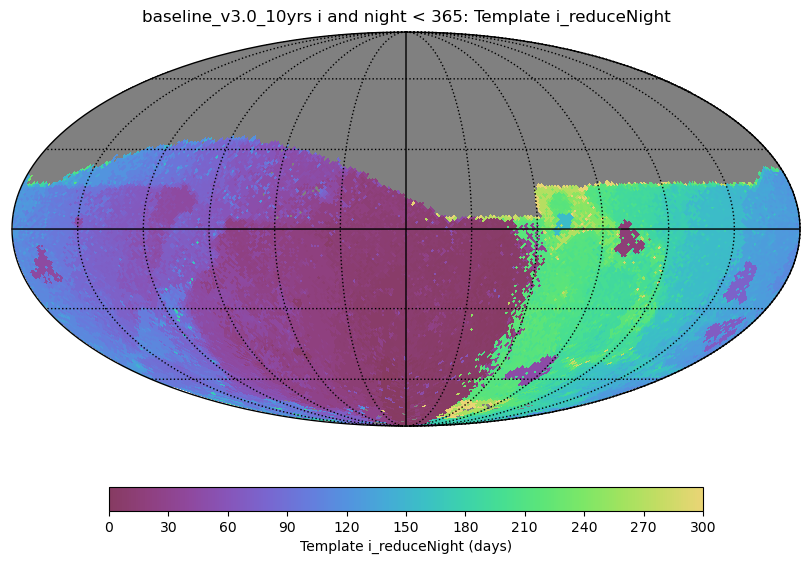

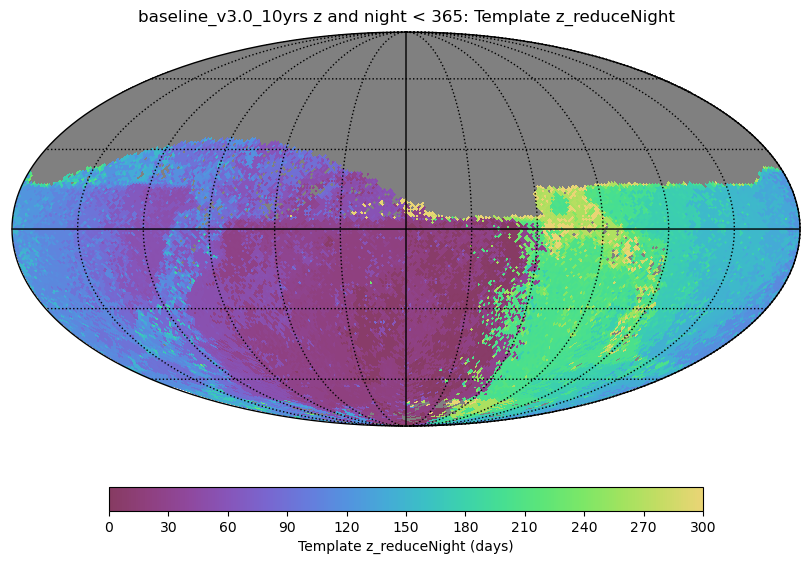

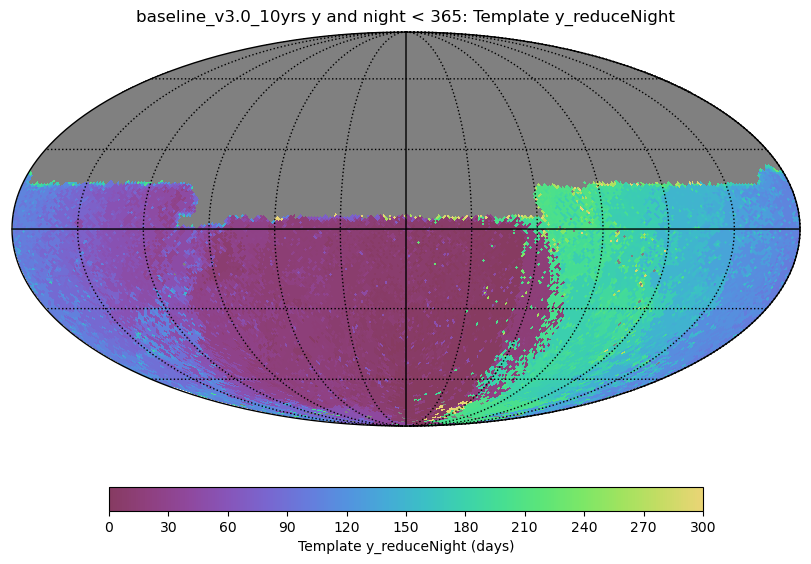

In [20]:
for f in 'ugrizy':
    k = f'Template {f}_reduceNight'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 0, 'color_max': 300}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)   

In [ ]:
for f in 'ugrizy':
    k = f'Template {f}_reduceImage'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 0, 'color_max': 180}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)
    
#returns days instead of images (need to fix)

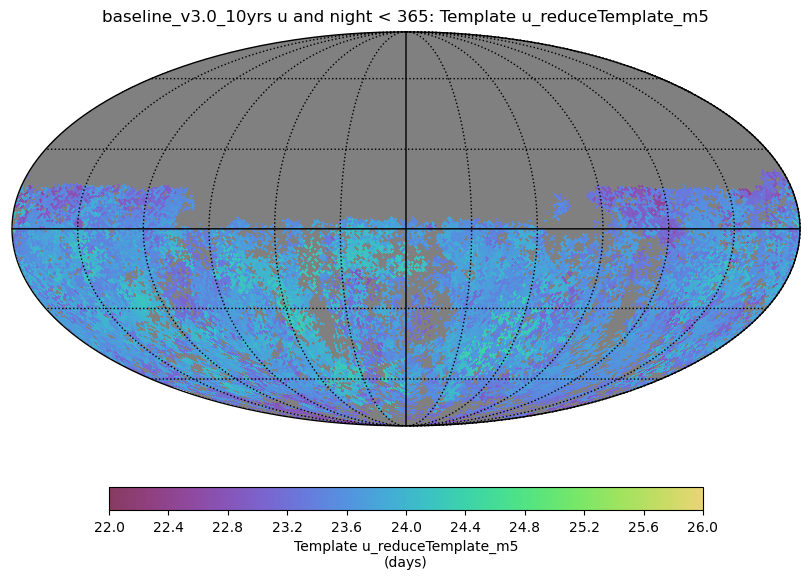

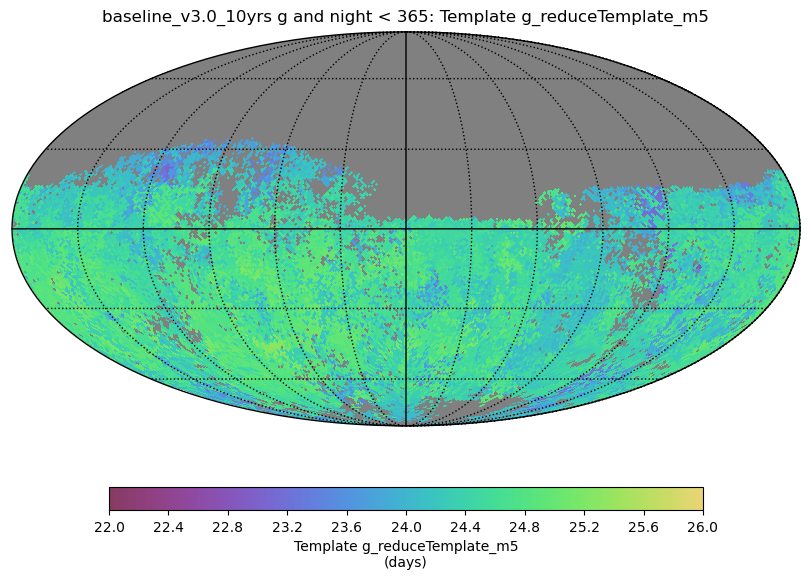

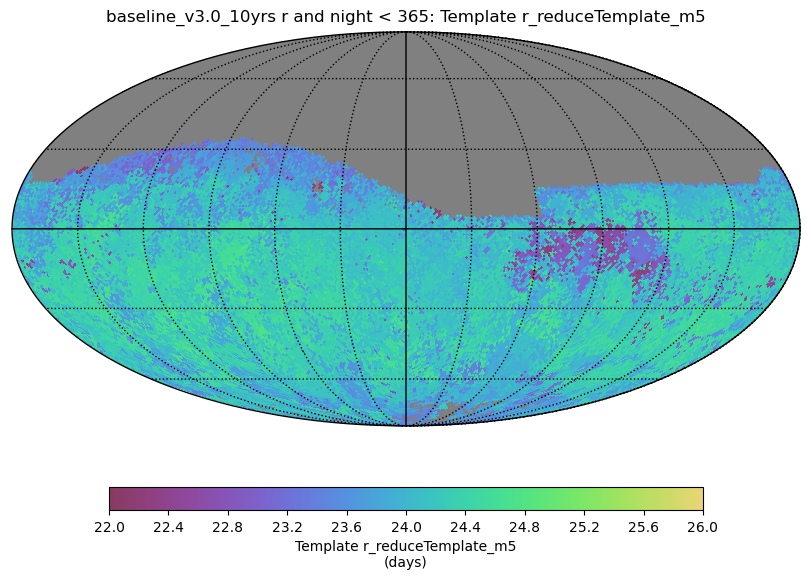

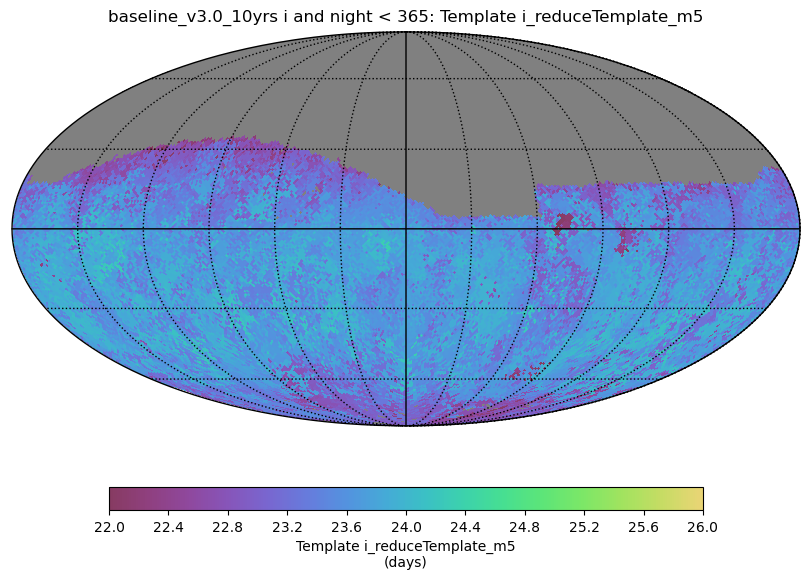

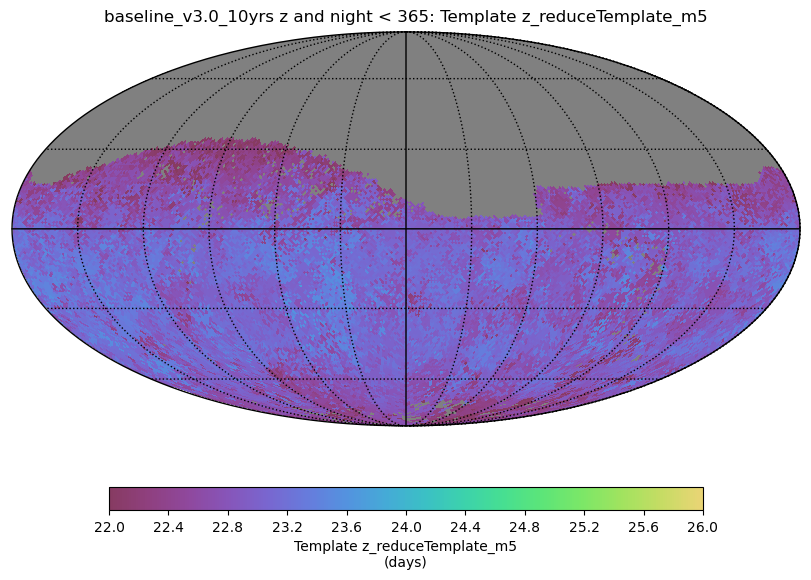

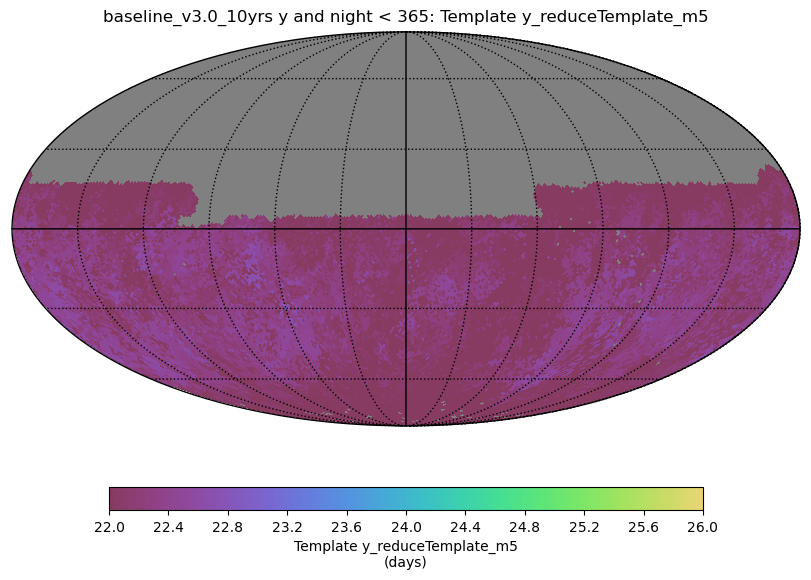

In [27]:
for f in 'ugrizy':
    k = f'Template {f}_reduceTemplate_m5'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 22, 'color_max': 26}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)

In [32]:
nights = np.arange(0, 3650, 1)
pixarea = hp.nside2pixarea(nside, degrees=True)
area_over_time = {}
area_since_first = {}
for f in 'ugrizy':
    k = f'Template {f}_reduceNight'
    counts, bins = np.histogram(bdict[k].metric_values.compressed(), bins=nights)
    area_over_time[f] = counts.cumsum() * pixarea 
    k = f'Template {f}_reduceDeltaNight'
    counts, bins = np.histogram(bdict[k].metric_values.compressed(), bins=nights)
    area_since_first[f] = counts.cumsum() * pixarea 

In [33]:
# Count up area in footprint, for reference (varies by filter)
footprint_area = {}
for f in 'ugrizy':
    k = f'Template {f}_reduceNight'
    footprint_area[f] = len(bdict[k].metric_values.compressed()) * pixarea

{'u': 24838.05613637927, 'g': 27924.97816346594, 'r': 28013.943289858325, 'i': 28000.514591534946, 'z': 27964.424964790865, 'y': 25037.808023939528}


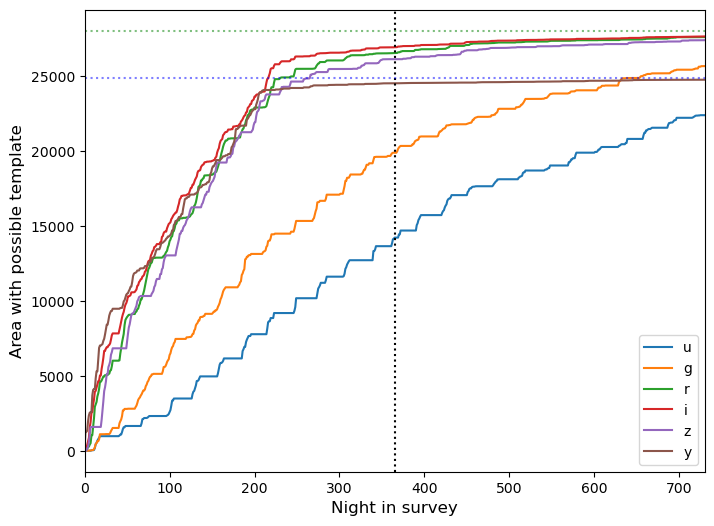

In [34]:
plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    plt.plot(nights[:-1], area_over_time[f], label=f)
plt.legend()
plt.xlim(0, 365*2)
plt.xlabel('Night in survey', fontsize='large')
plt.ylabel('Area with possible template', fontsize='large')
plt.axvline(365, color='k', linestyle=':')
plt.axhline(footprint_area['u'], color='b', linestyle=':', alpha=0.5)
plt.axhline(footprint_area['r'], color='g', linestyle=':', alpha=0.5)
print(footprint_area)

{'u': 24838.05613637927, 'g': 27924.97816346594, 'r': 28013.943289858325, 'i': 28000.514591534946, 'z': 27964.424964790865, 'y': 25037.808023939528}


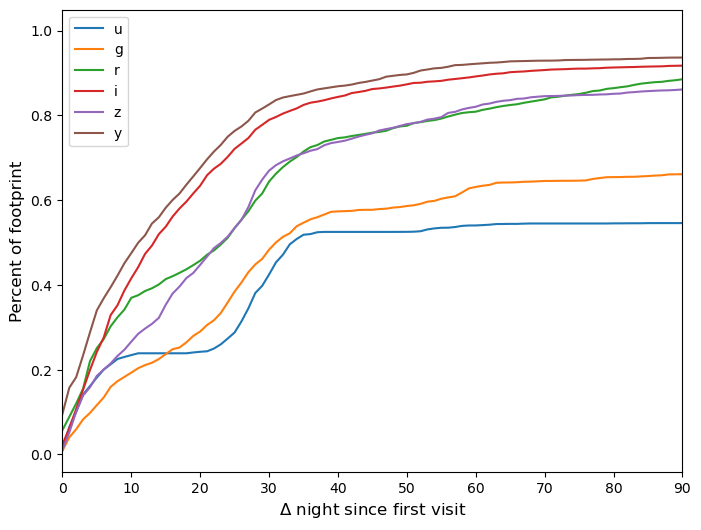

In [35]:
plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    # Show percent of footprint 
    plt.plot(nights[:-1], area_since_first[f] / footprint_area[f], label=f)
plt.legend()
plt.xlim(0, 365*2)
plt.xlim(0, 90)
plt.xlabel(r'$\Delta$ night since first visit', fontsize='large')
#plt.ylabel('Area with possible template', fontsize='large')
plt.ylabel('Percent of footprint', fontsize='large')
plt.axvline(365, color='k', linestyle=':')
print(footprint_area)

In [38]:
visit_maps= {}
for f in 'ugrizy':
    visit_maps[f + ' 1yr'] = maf.MetricBundle(maf.CountMetric(col='observationStartMJD', metric_name='Nvisits'),
                                    maf.HealpixSlicer(nside=128),
                                    f"night < 365.25 and filter = '{f}'", run_name=run_name)
    visit_maps[f + ' 2yr'] = maf.MetricBundle(maf.CountMetric(col='observationStartMJD', metric_name='Nvisits'),
                                    maf.HealpixSlicer(nside=128),
                                    f"night < 365.25*2 and filter = '{f}'", run_name=run_name)
g2 = maf.MetricBundleGroup(visit_maps, opsdb, 'temp')
g2.run_all()

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


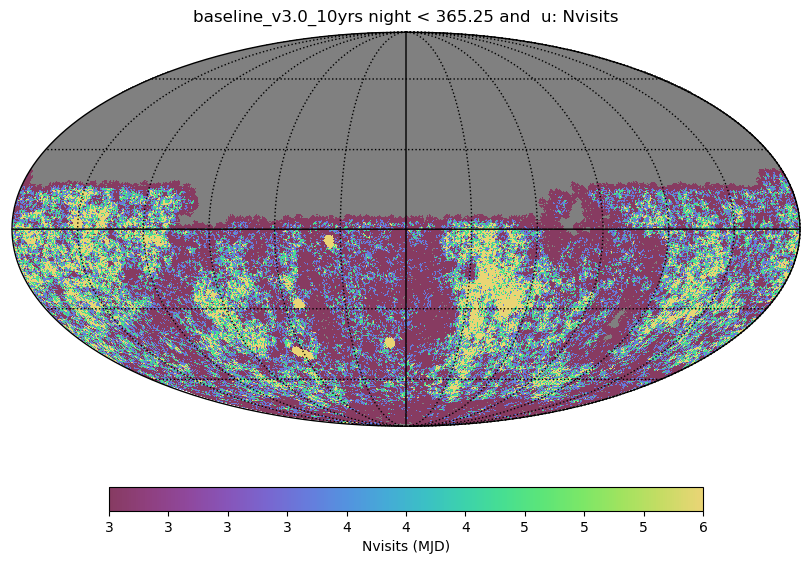

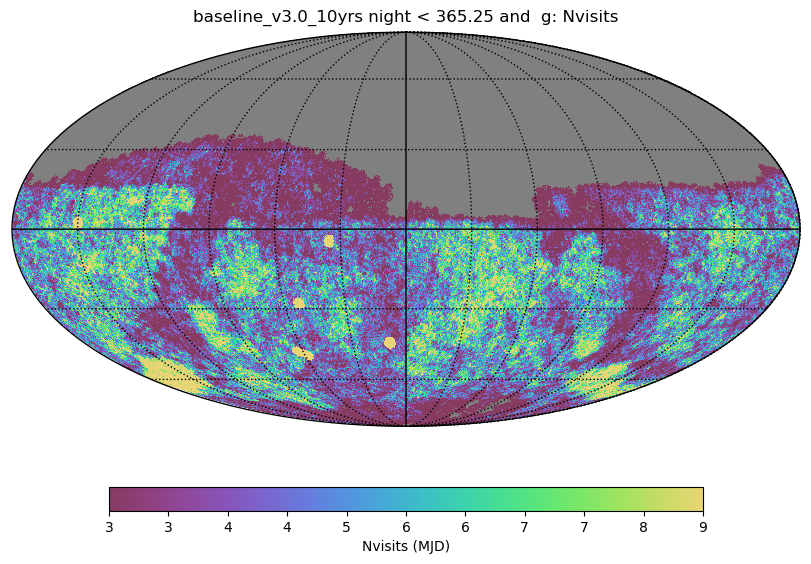

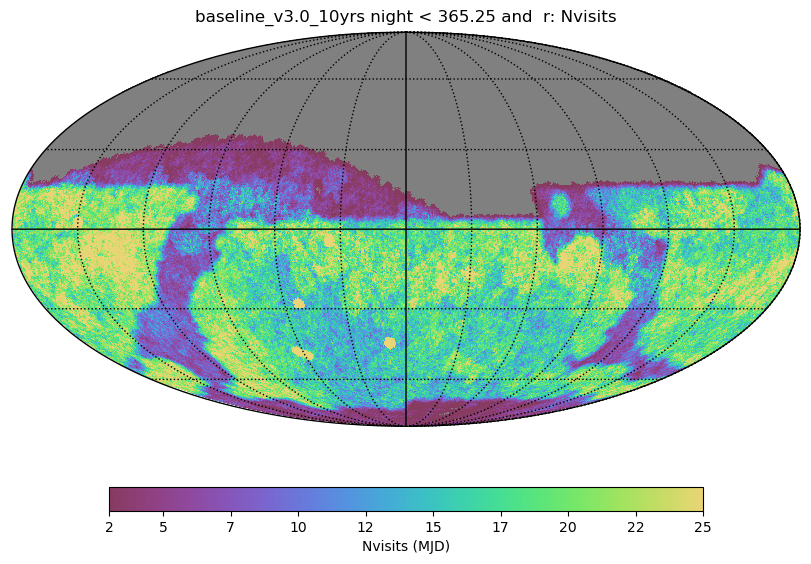

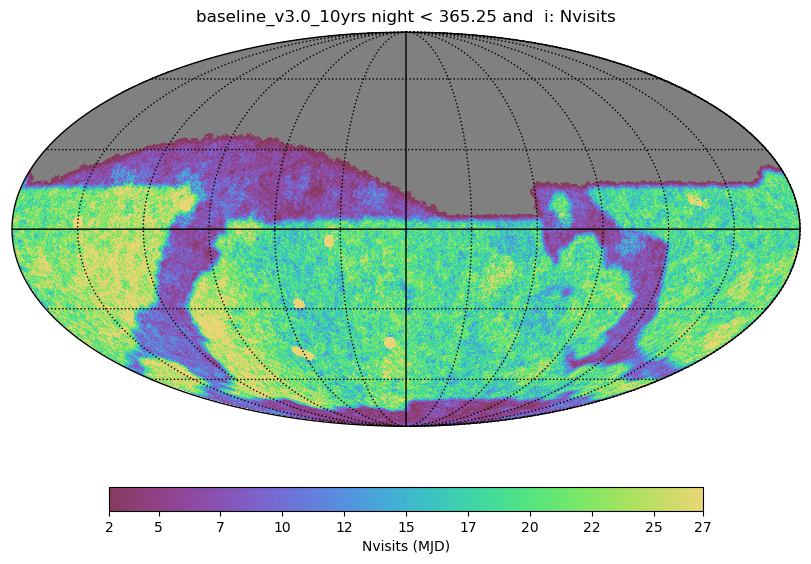

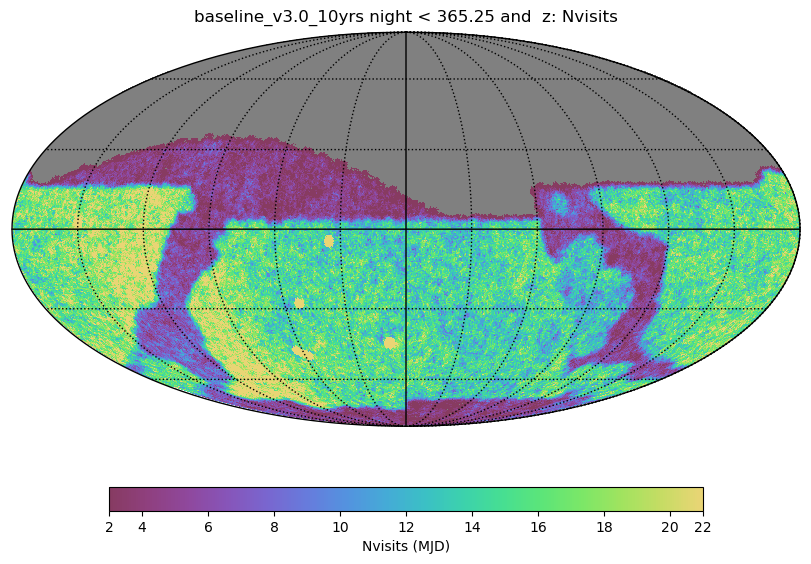

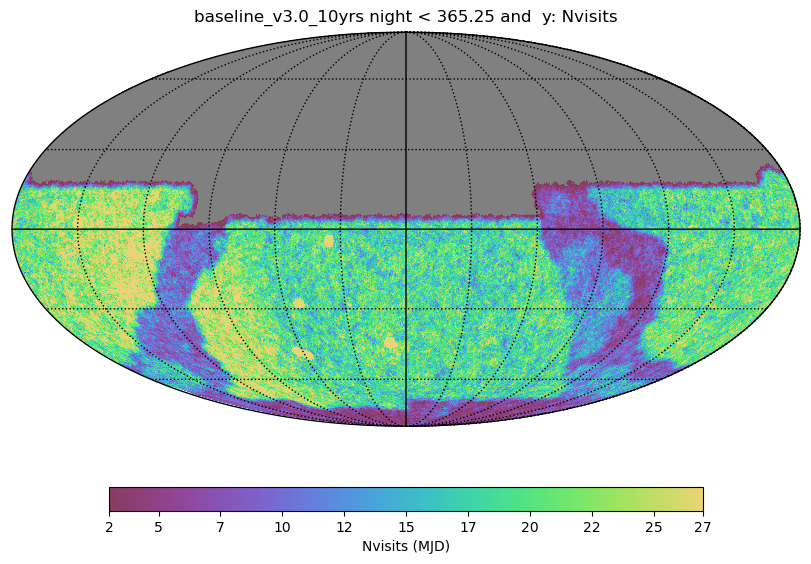

In [39]:
for f in 'ugrizy':
    k = f'{f} 1yr'
    ph.set_metric_bundles([visit_maps[k]])
    colormax = np.percentile(visit_maps[k].metric_values.compressed(), 95)
    plotDict = {'figsize': (8, 6), 'color_min': 3, 'color_max': colormax}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)